In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.float_format',lambda x:'%.3f' % x)
from pandas.tseries.offsets import *
from datetime import datetime, timedelta

C:\Users\YH817GQ\Anaconda3_new\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plot_series(time,series,format='-'):
    plt.figure(figsize=(0,6)).set_figwidth(15)
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time,series_num,format)
    else:
        plt.plot(time,series,format)
    
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.grid(True)
    plt.show

In [3]:
def train_test_split(data):
    size = int(len(data)*0.8)
    x_train = data.drop(columns=['close']).iloc[:size]
    x_test = data.drop(columns=['close']).iloc[size:]
    y_train = data['close'].iloc[:size]
    y_test = data['close'].iloc[size:]
    return x_train,x_test,y_train,y_test



def series_to_supervised(data,n_in=1,n_out=1,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df_temp = pd.DataFrame(data)
    cols,names = list(),list()
    for i in range(n_in,0,-1):
        cols.append(df_temp.shift(i))
        names+=[('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0,n_out):
        cols.append(df_temp.shift(-1))
        if i==0:
            names+=[('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names+=[('var%d(t+%d)' % (j+1,i)) for j in range(n_vars)]
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def reshape_data(train,test):
    reframed_train = series_to_supervised(train,1,1)
    reframed_test = series_to_supervised(test,1,1)
    
    train = reframed_train.values
    test = reframed_test.values
    
    train_X,y_train = train[:,:-1],train[:,-1]
    test_X,y_test = test[:,:-1], test[:,-1]
    
    x_train = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))
    return x_train,x_test,y_train,y_test




In [68]:
df = pd.read_csv('ongc.csv')

df['date'] = pd.to_datetime(df['date'])
df['weekday'] = df['date'].dt.dayofweek+1
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

df = pd.get_dummies(df,columns=['weekday','month','quarter'])
df['close'] = df['close'].ffill()

df = df.sort_values('date')
df.head()

,date,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
0,2022-01-02,170.600,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2022-01-04,167.850,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,2022-01-06,149.700,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2022-01-07,131.150,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,2022-01-08,138.400,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


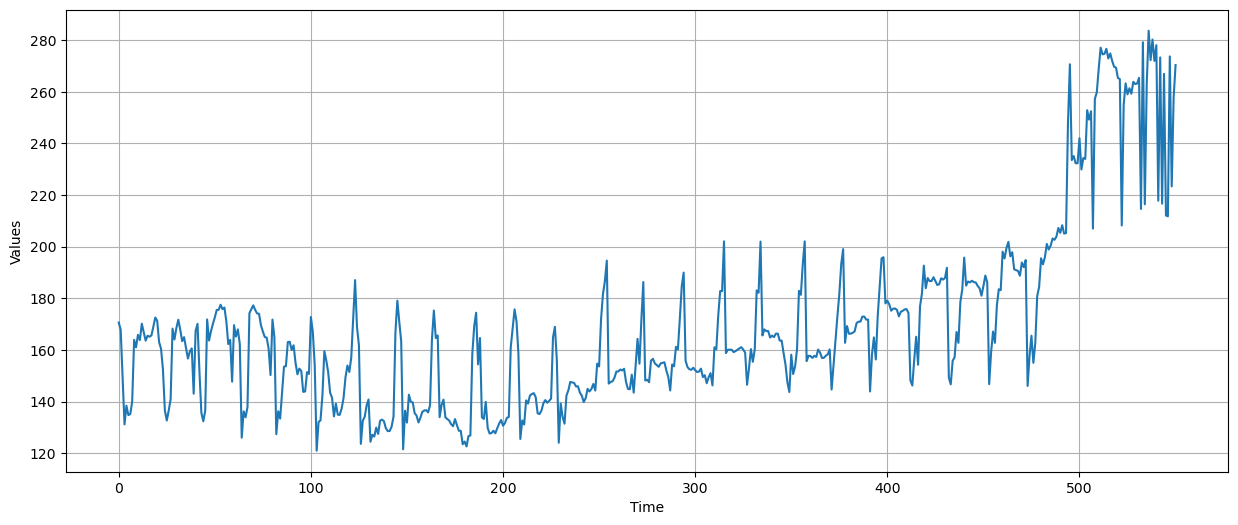

In [69]:
time = np.arange(len(df['close']))
series = df['close']
plot_series(time,series)

In [74]:
df.shape

(551, 47)

In [71]:
df[df['close'].isna()].shape

(0, 48)

In [72]:
df = df.set_index('date')
df.head()

,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-02,170.600,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-01-04,167.850,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-01-06,149.700,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-01-07,131.150,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-01-08,138.400,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [73]:
df.tail()

,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-01,211.750,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2024-11-03,273.700,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2024-12-01,223.350,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2024-12-02,257.800,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2024-12-03,270.350,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [19]:
df.columns

Index(['close', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weekday_7', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'quarter_1', 'quarter_2',
       'quarter_3', 'quarter_4'],
      dtype='object')

In [20]:
df1 = series_to_supervised(df[['close']],14,3).merge(df,how='left',on='date')
df1.head()

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-21,170.600,167.850,149.700,131.150,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,165.500,165.500,165.500,163.600,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-01-24,167.850,149.700,131.150,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,163.600,165.100,165.100,165.100,165.500,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-01-25,149.700,131.150,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,163.600,165.500,165.600,165.600,165.600,165.100,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-01-27,131.150,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,163.600,165.500,165.100,168.950,168.950,168.950,165.600,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2022-01-28,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,163.600,165.500,165.100,165.600,172.550,172.550,172.550,168.950,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [21]:
df1.columns

Index(['var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'var1(t)',
       'var1(t+1)', 'var1(t+2)', 'close', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object')

In [22]:
len(df1.columns)

41

In [23]:
df1 = df1[['var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'close', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4', 'var1(t)',
       'var1(t+1)', 'var1(t+2)']]
df1.head()

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4,var1(t),var1(t+1),var1(t+2)
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-21,170.600,167.850,149.700,131.150,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,163.600,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,165.500,165.500,165.500
2022-01-24,167.850,149.700,131.150,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,163.600,165.500,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,165.100,165.100,165.100
2022-01-25,149.700,131.150,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,163.600,165.500,165.100,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,165.600,165.600,165.600
2022-01-27,131.150,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,163.600,165.500,165.100,165.600,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,168.950,168.950,168.950
2022-01-28,138.400,134.750,135.150,140.000,163.900,161.000,165.850,163.800,170.150,166.850,163.600,165.500,165.100,165.600,168.950,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,172.550,172.550,172.550


In [24]:
df_X,df_Y = df1.values[:,:-3],df1.values[:,-3:]

In [25]:
df_X


array([[170.600006, 167.850006, 149.699997, ...,   0.      ,   0.      ,
          0.      ],
       [167.850006, 149.699997, 131.149994, ...,   0.      ,   0.      ,
          0.      ],
       [149.699997, 131.149994, 138.399994, ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [279.200012, 216.399994, 263.100006, ...,   0.      ,   0.      ,
          1.      ],
       [216.399994, 263.100006, 283.649994, ...,   0.      ,   0.      ,
          1.      ],
       [263.100006, 283.649994, 272.25    , ...,   0.      ,   0.      ,
          1.      ]])

In [26]:
df_Y

array([[165.5     , 165.5     , 165.5     ],
       [165.100006, 165.100006, 165.100006],
       [165.600006, 165.600006, 165.600006],
       ...,
       [223.350006, 223.350006, 223.350006],
       [257.799988, 257.799988, 257.799988],
       [270.350006, 270.350006, 270.350006]])

In [27]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])
Y = df_Y

In [28]:
X.shape,Y.shape

((536, 1, 38), (536, 3))

In [29]:
X

array([[[170.600006, 167.850006, 149.699997, ...,   0.      ,
           0.      ,   0.      ]],

       [[167.850006, 149.699997, 131.149994, ...,   0.      ,
           0.      ,   0.      ]],

       [[149.699997, 131.149994, 138.399994, ...,   0.      ,
           0.      ,   0.      ]],

       ...,

       [[279.200012, 216.399994, 263.100006, ...,   0.      ,
           0.      ,   1.      ]],

       [[216.399994, 263.100006, 283.649994, ...,   0.      ,
           0.      ,   1.      ]],

       [[263.100006, 283.649994, 272.25    , ...,   0.      ,
           0.      ,   1.      ]]])

In [30]:
Y

array([[165.5     , 165.5     , 165.5     ],
       [165.100006, 165.100006, 165.100006],
       [165.600006, 165.600006, 165.600006],
       ...,
       [223.350006, 223.350006, 223.350006],
       [257.799988, 257.799988, 257.799988],
       [270.350006, 270.350006, 270.350006]])

In [31]:
size = int(len(X)*0.8)
x_train = X[:size]
y_train = Y[:size]

x_test = X[size:]
y_test = Y[size:]

In [32]:
x_train.shape,y_train.shape

((428, 1, 38), (428, 3))

In [33]:
x_test.shape,y_test.shape

((108, 1, 38), (108, 3))

In [34]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(3))
model.compile(loss='mae',optimizer='adam')
history = model.fit(x_train,y_train,epochs=30,batch_size=50,verbose=1,shuffle=False)



Epoch 1/30

9/9 [==============================] - 1s 4ms/step - loss: 92.0059
Epoch 2/30
9/9 [==============================] - 0s 3ms/step - loss: 26.4239
Epoch 3/30
9/9 [==============================] - 0s 2ms/step - loss: 15.5868
Epoch 4/30
9/9 [==============================] - 0s 3ms/step - loss: 11.2310
Epoch 5/30
9/9 [==============================] - 0s 3ms/step - loss: 14.3440
Epoch 6/30
9/9 [==============================] - 0s 2ms/step - loss: 12.8254
Epoch 7/30
9/9 [==============================] - 0s 3ms/step - loss: 11.6165
Epoch 8/30
9/9 [==============================] - 0s 2ms/step - loss: 11.7908
Epoch 9/30
9/9 [==============================] - 0s 2ms/step - loss: 12.2778
Epoch 10/30
9/9 [==============================] - 0s 2ms/step - loss: 12.1794
Epoch 11/30
9/9 [==============================] - 0s 2ms/step - loss: 11.9055
Epoch 12/30
9/9 [==============================] - 0s 2ms/step - loss: 11.6687
Epoch 13/30
9/9 [==============================] - 0s 2ms/

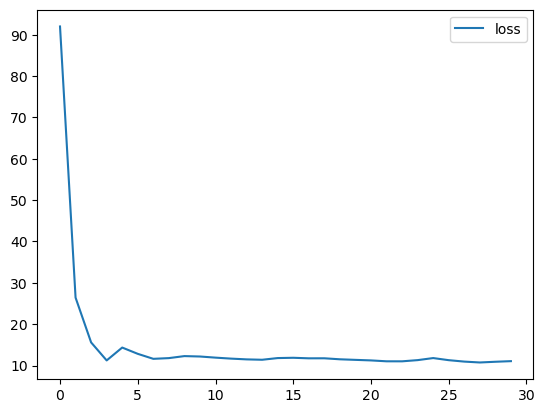

In [35]:
# Plot loss history
plt.plot(history.history['loss'],label='loss')
plt.legend()
plt.show()

In [36]:
y_test_pre = model.predict(x_test)
y_test_pre.shape,y_test.shape

4/4 [==============================] - 0s 2ms/step


((108, 3), (108, 3))

In [37]:
y_test_pre.shape

(108, 3)

In [38]:
y_test.shape

(108, 3)

In [39]:
len(list(pd.DataFrame(y_test).iloc[1:,0]))

107

In [40]:
len(list(pd.DataFrame(y_test_pre).iloc[:-1,0]))

107

In [41]:
# Make predictions
pred = pd.DataFrame()
pred['date'] = df1.reset_index()['date'][size:]
pred['predicted_close'] = list(pd.DataFrame(y_test_pre).iloc[:,0])
pred['actual_close'] = list(df1['var1(t-1)'][size:])
pred.head()

,date,predicted_close,actual_close
428,2023-10-16,182.923,184.900
429,2023-10-17,184.025,186.500
430,2023-10-18,184.844,186.150
431,2023-10-19,181.778,186.800
432,2023-10-20,182.762,186.250


4.681655156098778

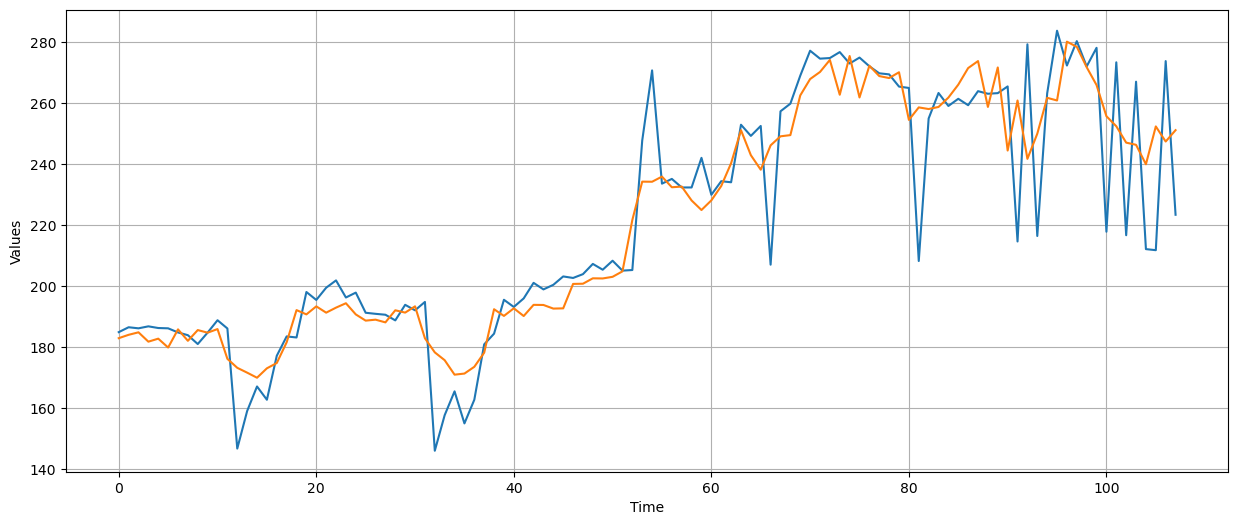

In [42]:
def measure_mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred) / y_true)) * 100

time = np.arange(len(pred))
series1 = pred['actual_close']
series2 = pred['predicted_close']
plot_series(time,(series1,series2))
display(measure_mape(series1,series2))

In [31]:
## oot forecasting

In [43]:
# Running LSTM

model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(3))
model.compile(loss='mae',optimizer='adam')
history = model.fit(X,Y,epochs=30,batch_size=50,verbose=1,shuffle=False)

Epoch 1/30
11/11 [==============================] - 1s 3ms/step - loss: 122.3721
Epoch 2/30
11/11 [==============================] - 0s 3ms/step - loss: 30.6516
Epoch 3/30
11/11 [==============================] - 0s 4ms/step - loss: 14.3419
Epoch 4/30
11/11 [==============================] - 0s 3ms/step - loss: 15.2119
Epoch 5/30
11/11 [==============================] - 0s 3ms/step - loss: 17.1540
Epoch 6/30
11/11 [==============================] - 0s 3ms/step - loss: 17.9529
Epoch 7/30
11/11 [==============================] - 0s 3ms/step - loss: 17.8435
Epoch 8/30
11/11 [==============================] - 0s 2ms/step - loss: 15.5570
Epoch 9/30
11/11 [==============================] - 0s 3ms/step - loss: 16.6910
Epoch 10/30
11/11 [==============================] - 0s 3ms/step - loss: 16.4342
Epoch 11/30
11/11 [==============================] - 0s 3ms/step - loss: 15.7525
Epoch 12/30
11/11 [==============================] - 0s 2ms/step - loss: 16.4400
Epoch 13/30
11/11 [=================

In [57]:
df.tail()

,close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-01,211.750,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2024-11-03,273.700,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2024-12-01,223.350,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2024-12-02,257.800,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2024-12-03,270.350,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [56]:
df1 = series_to_supervised(df[['close']].tail(15),14,0).merge(df,how='left',on='date')
df1

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-03,283.650,272.250,280.250,271.950,278.050,217.800,273.300,216.650,266.950,212.100,211.750,273.700,223.350,257.800,270.350,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [45]:
len(df1.columns)

38

In [46]:
df1 = df1[['var1(t-14)', 'var1(t-13)', 'var1(t-12)', 'var1(t-11)', 'var1(t-10)',
       'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)', 'var1(t-5)',
       'var1(t-4)', 'var1(t-3)', 'var1(t-2)', 'var1(t-1)', 'close', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4']]
df1.head()

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-03,283.650,272.250,280.250,271.950,278.050,217.800,273.300,216.650,266.950,212.100,211.750,273.700,223.350,257.800,270.350,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [47]:
df1.tail()

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),close,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_1,quarter_2,quarter_3,quarter_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-03,283.650,272.250,280.250,271.950,278.050,217.800,273.300,216.650,266.950,212.100,211.750,273.700,223.350,257.800,270.350,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


In [48]:
df_X = df1.values[:,:]

In [49]:
df_X.shape

(1, 38)

In [50]:
X = df_X.reshape(df_X.shape[0],1,df_X.shape[1])

In [51]:
X.shape

(1, 1, 38)

In [52]:
X

array([[[283.649994, 272.25    , 280.25    , 271.950012, 278.049988,
         217.800003, 273.299988, 216.649994, 266.950012, 212.100006,
         211.75    , 273.700012, 223.350006, 257.799988, 270.350006,
           0.      ,   1.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
           0.      ,   0.      ,   0.      ,   1.      ,   0.      ,
           0.      ,   0.      ,   1.      ]]])

In [53]:
d = pd.DataFrame()
# d['eod_date'] = pd.bdate_range(start=pd.to_datetime('2024-03-25'),end=pd.to_datetime('2024-03-25')+pd.DateOffset(3))
d['forecast'] = model.predict(X)[0]

1/1 [==============================] - 0s 127ms/step


In [54]:
d

,forecast
0,253.904
1,252.099
2,252.293


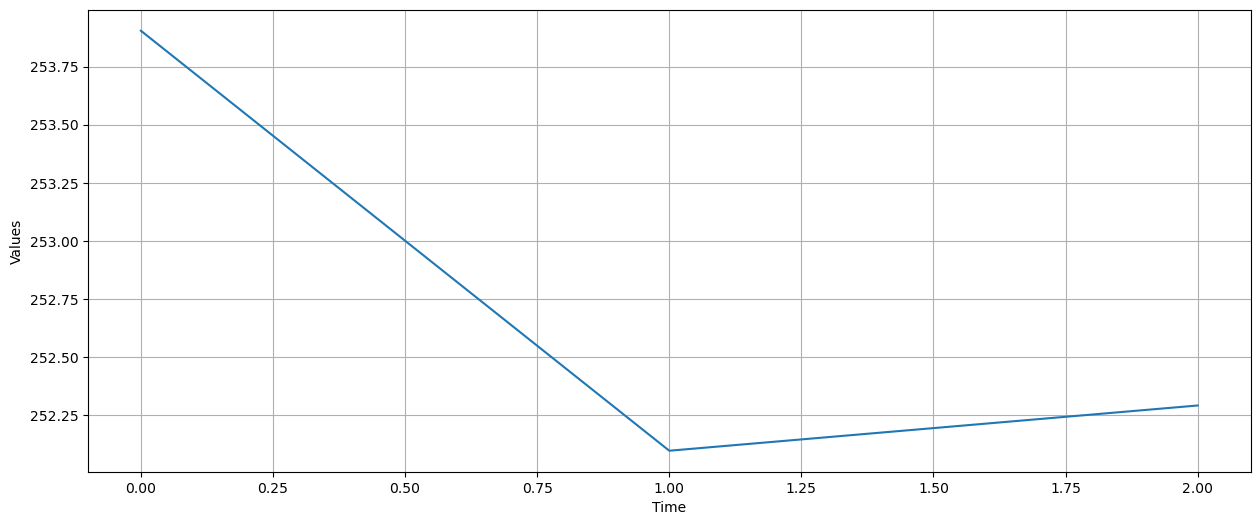

In [55]:
time = np.arange(len(d))
series1 = d['forecast']
# series2 = pred['predicted_close']
plot_series(time,(series1))
# display(measure_mape(series1,series2))